In [2]:
# Libraries
from bs4 import BeautifulSoup, Comment
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import random
import urllib
import urllib2
import os
import re
import scipy.stats as stats
import unicodedata
import datetime
import requests
import requests_cache
requests_cache.install_cache('demo_cache')
%matplotlib inline

In [5]:
from selenium import webdriver
link = 'https://stats.nba.com/players/touches/'

driver = webdriver.Chrome('/Users/danielalpert/Desktop/Thesis/chromedriver')
driver.get(link)
html = driver.page_source
soup = BeautifulSoup(html, "lxml")

In [6]:
soup

<!DOCTYPE html>\n<html lang="en" ng-app="stats" ng-strict-di="" stats-build-date="2018-02-05 02:33 PM" stats-version="4.7.0" xmlns="http://www.w3.org/1999/xhtml" xmlns:ng="http://angularjs.org"><head class="at-element-marker"><style type="text/css">@charset "UTF-8";[ng\\:cloak],[ng-cloak],[data-ng-cloak],[x-ng-cloak],.ng-cloak,.x-ng-cloak,.ng-hide:not(.ng-hide-animate){display:none !important;}ng\\:form{display:block;}.ng-animate-shim{visibility:hidden;}.ng-anchor{position:absolute;}</style>\n<meta charset="unicode-escape"/>\n<meta content="IE=Edge,chrome=1" http-equiv="X-UA-Compatible"/><script src="https://bam.nr-data.net/1/09f0cb5c68?a=76210961&amp;v=1071.385e752&amp;to=NgcGZUJQVxYEVEJcCQ9NMUNZHkkJBE5TRxVOFgtEU1lcFkpeWFEDGUwUWUA%3D&amp;rst=3763&amp;ref=https://stats.nba.com/players/touches/&amp;ap=16&amp;be=90&amp;fe=3694&amp;dc=855&amp;perf=%7B%22timing%22:%7B%22of%22:1518499132217,%22n%22:0,%22f%22:7,%22dn%22:8,%22dne%22:16,%22c%22:16,%22s%22:25,%22ce%22:44,%22rq%22:44,%22rp%22:67

In [7]:
soup.find('div', class_='nba-stat-table')

<div class="nba-stat-table">\n<div class="nba-stat-table__overflow" data-fixed="1" role="grid">\n<div class="table-responsive">\n<table class="table">\n<thead>\n<tr>\n<th cf="" class="player" data-field="PLAYER_NAME" ripple="" sort=""><br/>Player</th>\n<th cf="" class="text" data-field="TEAM_ABBREVIATION" ripple="" sort="">Team</th>\n<th cf="" data-field="GP" ripple="" sort="">GP</th>\n<th cf="" data-field="W" ripple="" sort="">W</th>\n<th cf="" data-field="L" ripple="" sort="">L</th>\n<th cf="" data-field="MIN" ripple="" sort="">MIN</th>\n<th cf="" data-field="POINTS" ripple="" sort="">PTS</th>\n<th cf="" data-field="TOUCHES" ripple="" sort="">TOUCHES</th>\n<th cf="" data-field="FRONT_CT_TOUCHES" ripple="" sort="">Front\xa0CT<br/>Touches</th>\n<th cf="" data-field="TIME_OF_POSS" ripple="" sort="">Time\xa0Of<br/>Poss</th>\n<th cf="" data-field="AVG_SEC_PER_TOUCH" ripple="" sort="">Avg\xa0Sec\xa0Per<br/>Touch</th>\n<th cf="" data-field="AVG_DRIB_PER_TOUCH" ripple="" sort="">Avg\xa0Drib\

In [8]:
soup

<!DOCTYPE html>\n<html lang="en" ng-app="stats" ng-strict-di="" stats-build-date="2018-02-05 02:33 PM" stats-version="4.7.0" xmlns="http://www.w3.org/1999/xhtml" xmlns:ng="http://angularjs.org"><head class="at-element-marker"><style type="text/css">@charset "UTF-8";[ng\\:cloak],[ng-cloak],[data-ng-cloak],[x-ng-cloak],.ng-cloak,.x-ng-cloak,.ng-hide:not(.ng-hide-animate){display:none !important;}ng\\:form{display:block;}.ng-animate-shim{visibility:hidden;}.ng-anchor{position:absolute;}</style>\n<meta charset="unicode-escape"/>\n<meta content="IE=Edge,chrome=1" http-equiv="X-UA-Compatible"/><script src="https://bam.nr-data.net/1/09f0cb5c68?a=76210961&amp;v=1071.385e752&amp;to=NgcGZUJQVxYEVEJcCQ9NMUNZHkkJBE5TRxVOFgtEU1lcFkpeWFEDGUwUWUA%3D&amp;rst=3763&amp;ref=https://stats.nba.com/players/touches/&amp;ap=16&amp;be=90&amp;fe=3694&amp;dc=855&amp;perf=%7B%22timing%22:%7B%22of%22:1518499132217,%22n%22:0,%22f%22:7,%22dn%22:8,%22dne%22:16,%22c%22:16,%22s%22:25,%22ce%22:44,%22rq%22:44,%22rp%22:67

## Make Ginis

In [106]:
df = pd.read_excel('data/ball_touch_data/nba_touches_2017.xlsx')

In [107]:
df.head()

,player,team,G,min,touches,time_of_poss,avg_sec_touch
0,AJ Hammons,DAL,22,7.4,7.4,0.2,1.85
1,Aaron Brooks,IND,64,13.6,27.9,2.6,5.58
2,Aaron Gordon,ORL,80,28.9,38.7,1.6,2.41
3,Aaron Harrison,CHH,5,3.3,5.4,0.3,3.25
4,Adreian Payne,MIN,18,7.5,16.0,0.5,1.76


In [108]:
team_df = df[df['team'] == 'BOS']
team_df = team_df[team_df['G'] > 50]

In [109]:
team_df['tofp_2'] = [(touch * sec)/60 for touch, sec in zip(team_df['touches'], team_df['avg_sec_touch'])]

In [110]:
team_df

,player,team,G,min,touches,time_of_poss,avg_sec_touch,tofp_2
5,Al Horford,BOS,68,32.3,67.0,2.1,1.92,2.144000
17,Amir Johnson,BOS,80,20.1,30.4,0.8,1.50,0.760000
36,Avery Bradley,BOS,55,33.4,49.8,2.0,2.37,1.967100
176,Isaiah Thomas,BOS,76,33.8,85.2,7.0,4.90,6.958000
186,Jae Crowder,BOS,72,32.4,49.9,1.4,1.70,1.413833
208,Jaylen Brown,BOS,78,17.2,21.9,0.8,2.05,0.748250
234,Jonas Jerebko,BOS,78,15.8,29.2,0.7,1.48,0.720267
261,Kelly Olynyk,BOS,75,20.5,42.8,1.2,1.66,1.184133
312,Marcus Smart,BOS,79,30.4,57.2,3.5,3.67,3.498733
436,Terry Rozier,BOS,74,17.1,37.4,2.6,4.20,2.618000


In [111]:
def calculate_tofp(team_df):
    tofp = [(touch * sec)/60 for touch, sec in zip(team_df['touches'], team_df['avg_sec_touch'])]
    return tofp

In [112]:
# Take usage rates, normalize them (sum = 1), sort them
def get_norm_touch(touches):
    return sorted([t/sum(touches) for t in touches])

In [113]:
# Subset only the top k usages, renormalize them
def get_norm_top_k(n_touch, k):
    new_touch = n_touch[-k:]
    return get_norm_touch(new_touch)

In [114]:
n_touch = get_norm_touch(team_df['tofp_2'])

In [115]:
n_touch

[0.017636938795091824,
 0.032143975496317825,
 0.033392812382154496,
 0.033917189990561196,
 0.05284536215897788,
 0.06309638655480936,
 0.08778750582951701,
 0.09568217807863579,
 0.11683579394117004,
 0.15614105683286336,
 0.31052079993990106]

In [116]:
n_touch_k = get_norm_top_k(n_touch, 8)

In [117]:
n_touch_k

[0.03699412961574782,
 0.057639450020606366,
 0.06882043893210281,
 0.09575151627254938,
 0.10436238670547804,
 0.12743504122898397,
 0.1703060452950931,
 0.3386909919294386]

In [118]:
def get_gini_touch_season(team_df, k):
    tofp = calculate_tofp(team_df)
    n_touch = get_norm_touch(tofp)
    n_touch_k = get_norm_top_k(n_touch, k=k)
    x = range(len(n_touch_k)+1)
    y1 = np.cumsum([0] + n_touch_k)
    y2 = [float(t)/(len(x)-1) for t in x]
    gini = 2*(np.trapz(y2) - np.trapz(y1))/(x[-1]*y1[-1]) * len(n_touch_k)/(len(n_touch_k)-1)
    return gini

In [119]:
get_gini_touch_season(team_df, 9)

0.43036133204646809

In [120]:
s_res = pd.read_excel('data/nba_results.xlsx')

In [121]:
s_res.head()

,Team,W,L,WL_pct,PW,PL,PS/G,PA/G,yr,abbr,playoffs
0,Boston Celtics,53,29,0.646,48,34,108.0,105.4,2017,BOS,3
1,Cleveland Cavaliers,51,31,0.622,49,33,110.3,107.2,2017,CLE,4
2,Toronto Raptors,51,31,0.622,52,30,106.9,102.6,2017,TOR,2
3,Washington Wizards,49,33,0.598,46,36,109.2,107.4,2017,WAS,2
4,Atlanta Hawks,43,39,0.524,39,43,103.2,104.0,2017,ATL,1


In [122]:
s_res[(s_res['yr'] == 2017) & (s_res['abbr'] == 'BOS')]['playoffs'].values[0]

3

In [123]:
gini_log = pd.DataFrame()
for team in np.unique(df['team']):
    print team
    team_df = df[df['team'] == team]
    gini = get_gini_touch_season(team_df, 9)
    playoffs = s_res[(s_res['yr'] == 2017) & (s_res['abbr'] == team)]['playoffs'].values[0]
    gini_log = gini_log.append({
            'team': team,
            'gini': gini,
            'playoffs': playoffs},
            ignore_index=True)

ATL
BOS
BRK
CHH
CHI
CLE
DAL
DEN
DET
GSW
HOU
IND
LAC
LAL
MEM
MIA
MIL
MIN
NOP
NYK
OKC
ORL
PHI
PHO
POR
SAC
SAS
TOR
UTA
WAS


In [124]:
gini_log

,gini,playoffs,team
0,0.350249,1.0,ATL
1,0.430361,3.0,BOS
2,0.204851,0.0,BRK
3,0.399191,0.0,CHH
4,0.355150,1.0,CHI
5,0.425119,4.0,CLE
6,0.306415,0.0,DAL
7,0.234218,0.0,DEN
8,0.406099,0.0,DET
9,0.322217,5.0,GSW


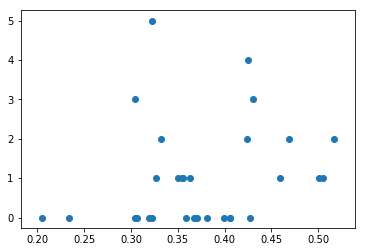

In [125]:
plt.scatter(gini_log['gini'], gini_log['playoffs'])
plt.show()

## Expand to all years of data

In [164]:
def get_ball_touch_gini_log(yr):
    df = pd.read_excel('data/ball_touch_data/nba_touches_' + str(yr) + '.xlsx')
    gini_log = pd.DataFrame()
    for team in np.unique(df['team']):
        #print team
        team_df = df[df['team'] == team]
        gini = get_gini_touch_season(team_df, 9)
        playoffs = s_res[(s_res['yr'] == yr) & (s_res['abbr'] == team)]['playoffs'].values[0]
        gini_log = gini_log.append({
                'team': team,
                'gini': gini,
                'playoffs': playoffs},
                ignore_index=True)
    return gini_log

In [165]:
yr = 2014
g_log = get_ball_touch_gini_log(yr)

In [166]:
g_log = pd.DataFrame()
for yr in range(2014,2018):
    g_log = g_log.append(get_ball_touch_gini_log(yr))

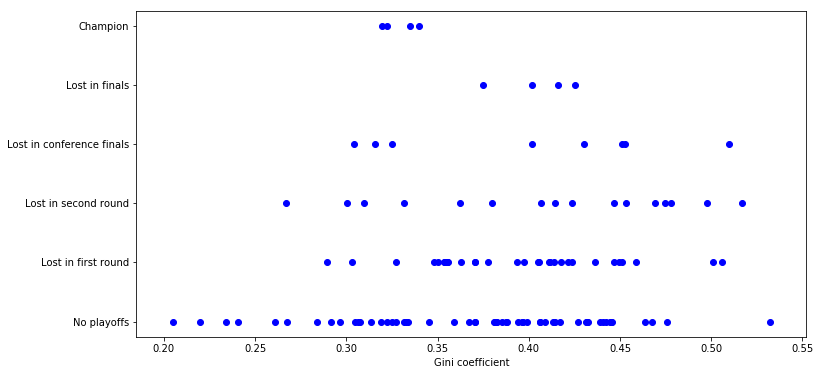

In [170]:
plt.figure(figsize=(12,6))
plt.scatter(g_log['gini'], g_log['playoffs'], c='b')
plt.yticks( range(6), ('No playoffs', 'Lost in first round', 'Lost in second round', 
                       'Lost in conference finals', 'Lost in finals', 'Champion') )
plt.xlabel('Gini coefficient')
plt.show()

In [168]:
g_log[g_log['playoffs'] == 5]

,gini,playoffs,team
26,0.319657,5.0,SAS
9,0.334728,5.0,GSW
5,0.339855,5.0,CLE
9,0.322217,5.0,GSW
